# Classify Magnetic Structure

In [5]:
import os
num_thread = 16
os.environ['OMP_NUM_THREADS'] = str(num_thread)
os.environ['OPENBLAS_NUM_THREADS'] = str(num_thread)

import re
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from mlmag import mlmag

mcns = ['rf', 'xgb', 'lgbm', 'cat']
mcnfs = ['(a) RF', '(b) XGB', '(c) LGBM', '(d) CB']
dmft_cols = ['JU', 'N', 'm', 'U', 'type', 'type_p', 'score']
dmft_dict = {
    'N':   'Hz',
    'm':   'D',
    'gap': 'th'
}
plt.rcParams.update({'font.size': 32})
ml = mlmag.MLMag('dU1.0_UF8.0', num_thread=num_thread, random_state=100)
types = list(ml.type_dict)

def ShowConfMat(dn, mcn, ftn, mcnf):
    fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
    
    y = ml.Train(dn, mcn, ftn, 'none')
    im = ml.DrawConfMat(y[0], y[1], ax)
    
    ax.set_title(mcnf, y=1.1)
    ax.set_xticks(range(3), labels=types)
    ax.set_yticks(range(3), labels=types)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')

    cb = fig.colorbar(im, ax=ax, pad=0.02)
    cb.set_ticks([0, 1])
    plt.show()
def ShowConfMats(dn, mcns, mcnfs, verbose=False, pca=False, show_xticks=True):
    fig, ax = plt.subplots(1, 4, figsize=(18, 5), constrained_layout=True)
    is_validate = True if type(dn) is list else False
    show_yticks = True
    xpad = -0.4
    ypad = -0.12
    
    for i, (mcn, mcnf) in enumerate(zip(mcns, mcnfs)):
        if is_validate: y = ml.Validate(dn, mcn, 'none', 'none', is_verbose=verbose)
        else:           y = ml.Train(dn, mcn, 'none', 'none', is_verbose=verbose)
        
        im = ml.DrawConfMat(y[0], y[1], ax[i])
        
        ax[i].set_title(mcnf, ha='left', x=xpad, y=1.1)
        ax[i].set_xticks(range(3))
        ax[i].set_yticks(range(3))
        ax[i].set_xticklabels(types)
        ax[i].set_yticklabels(types)
        ax[i].set_ylabel('\nTrue', fontsize='large')
        
        if not show_xticks:
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('')
        if not show_yticks:
            ax[i].set_yticklabels([])
            ax[i].set_ylabel('')
            
        show_yticks = False
        xpad = -0.1
            
    cb = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.75, pad=0.02)
    cb.set_ticks([0, 1])
    fig.get_layout_engine().set(wspace=0.1)
    xlabel = 'Predicted' if show_xticks else ' '
    fname = dn[1] if is_validate else dn
    fig.supxlabel(xlabel, fontsize='large', y=ypad)
    #fig.savefig('diagram/%s/conf_%s.pdf' % (save, fname), bbox_inches='tight')
    plt.show()
def ShowAcc(dtype, ftn, ep):
    fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
    
    strain_list = [a * 0.01 for a in range(95, 106)]
    acc = []
    for strain in strain_list:
        dn = '%s_a%.2f_m0.10/bins128_ep%.2f.h5' % (dtype, strain, ep)
        y = ml.Train(dn, 'rf', ftn, 'none')
        acc.append(accuracy_score(y[0], y[1]))
    ax.plot(strain_list, acc)
    ax.set_title('', y=1.1)
    #ax.set_xticks(range(3), labels=labels)
    #ax.set_yticks(range(3), labels=labels)
    #ax.set_ylabel('True')
    #ax.set_xlabel('Predicted')
    plt.show()
def ShowPeak(name, dn, type, JU, N, U, fermi_idx=0, xlim=20):
    bins = int(re.sub('bins', '', re.search('bins\d+', dn).group()))\
    if re.search('bins', dn)\
    else ml.BINS_MAX
    binsh = bins//2
    
    fmt = ['', '\n', '', '']
    yticks = [0, binsh-1, binsh, bins-1]
    yticklabels = [['%s%s%02d%s'%(f, l, i+1, b)\
                    for i, f, b in zip(yticks, fmt, fmt[::-1])]\
                   for l in ml.hsp_label]
    
    fig, ax = plt.subplots(1, 4,\
                           figsize=(14, 6),\
                           dpi=300,\
                           constrained_layout=True)
    
    for i in range(ml.Nhsp):
        y, _, peak = ml.DrawDOS(dn, type[0], JU, N, U, fermi_idx=fermi_idx, point=i)
        x = range(len(y))
        ax[i].barh(x[:binsh], y[:binsh])
        ax[i].barh(x[binsh:], y[binsh:], color='tab:red')
        ax[i].text(0.9, 0.95, ml.hsp_label[i].replace('G', r'$\Gamma$'),\
                   transform=ax[i].transAxes, size=28, va='top', ha='right',\
                   bbox=dict(boxstyle='square', fc='none', ec='k'))
        ax[i].set_xlim(0, xlim*1.2)
        ax[i].set_xticks([0, xlim], labels=[0, xlim], fontsize='small')
        ax[i].set_yticks(yticks, yticklabels[i], fontsize='small')
        ax[i].axhline(np.median(x), ls=':', lw=2, color='dimgrey')

        """
        for j in range(ml.PEAK_MAX):
            color = 'r' if peak[j][1] > binsh else 'b'
            coord = (peak[j][0]+xlim*0.1, peak[j][1])
            ax[i].annotate('', xy=coord, xycoords='data',\
                          xytext=(coord[0]+xlim*0.3, coord[1]), textcoords='data',
                          arrowprops=dict(arrowstyle="simple",\
                                          connectionstyle="arc3",\
                                          color=color))
        """
    ax[0].set_ylabel('Feature index', fontsize='large')
    ax[1].set_xlabel(r'                   $\rho_{\bf{k}}$', fontsize='large')
    #fig.savefig('diagram/%s/dmft/peak.pdf' % name)
    plt.show()

output/dU1.0_UF8.0_sm/a0.95_G0_JU0.00//diagram/N8.0_U2.0_n7.997624_m1.470671_e91.401459_gap0.001329_fermi12.611128_dntop12.610667_v591936.png


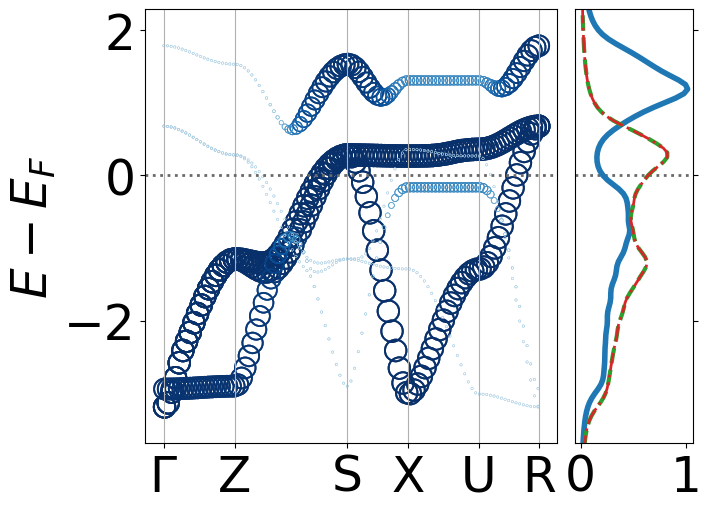

2.0 [(4.0, ['G1']), (5.0, ['G1']), (6.0, ['G1']), (7.0, ['G1']), (8.0, ['G1'])]
4.0 [(4.0, ['G0']), (5.0, ['G0']), (6.0, ['G0']), (7.0, ['G0']), (8.0, ['G0'])]
6.0 [(2.0, ['G0']), (3.0, ['G0']), (4.0, ['G0']), (5.0, ['G0']), (6.0, ['G0']), (7.0, ['G0']), (8.0, ['G1'])]
8.0 [(3.0, ['G6']), (4.0, ['G6']), (5.0, ['G6']), (6.0, ['G6']), (7.0, ['G6']), (8.0, ['G6'])]
10.0 [(2.0, ['G0']), (3.0, ['G0']), (4.0, ['G0']), (5.0, ['G0']), (6.0, ['G0']), (7.0, ['G0']), (8.0, ['G0'])]
output/dU1.0_UF8.0_sm/a0.95_G0_JU0.00//diagram/phase.png


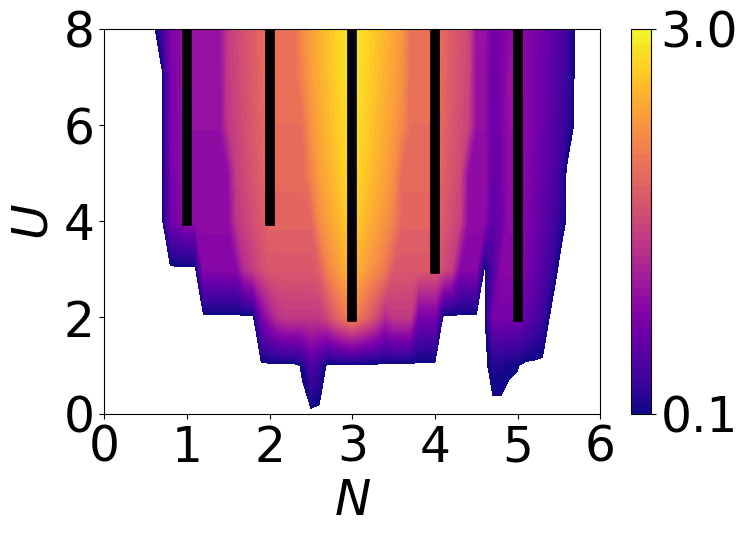

output/dU1.0_UF8.0_sm/a1.00_G0_JU0.00//diagram/N8.0_U2.0_n7.996827_m1.945033_e91.826027_gap0.000181_fermi12.554008_dntop12.553883_v592025.png


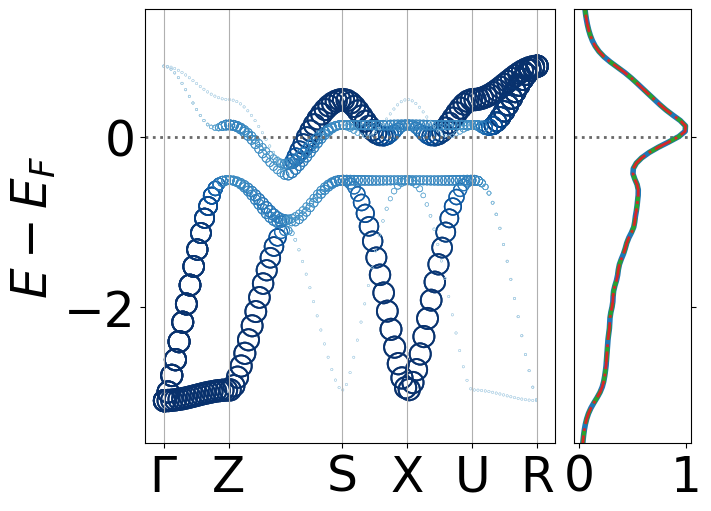

6.0 [(2.0, ['G0']), (3.0, ['G0']), (4.0, ['G0']), (5.0, ['G0']), (6.0, ['G0']), (7.0, ['G0']), (8.0, ['G0'])]
output/dU1.0_UF8.0_sm/a1.00_G0_JU0.00//diagram/phase.png


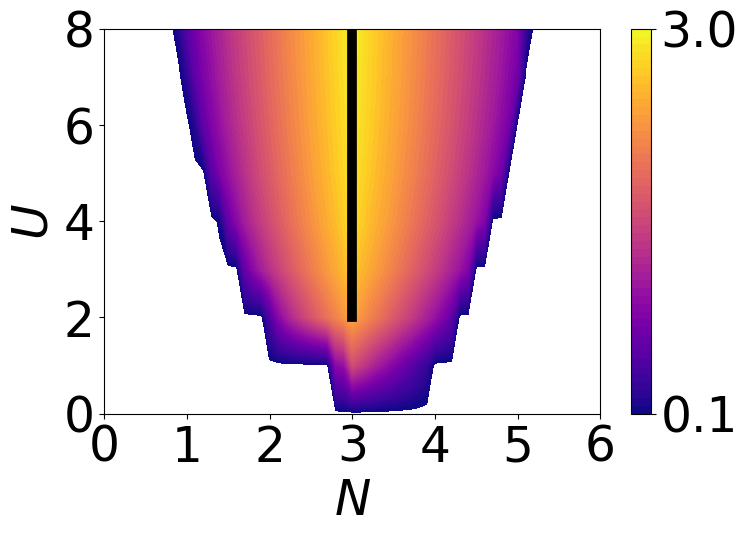

output/dU1.0_UF8.0_sm/a1.05_G0_JU0.00//diagram/N8.0_U2.0_n8.000000_m2.526650_e89.446594_gap0.682540_fermi12.917253_dntop12.313091_v591929.png


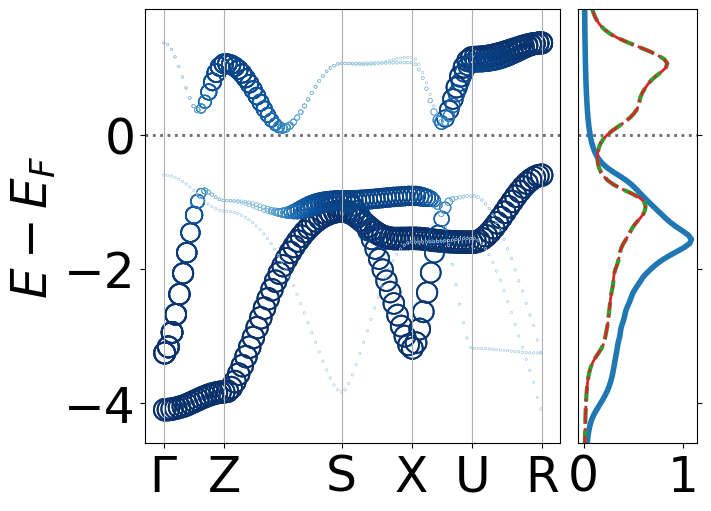

2.0 [(3.0, ['G0']), (4.0, ['G0']), (5.0, ['G0']), (6.0, ['G0']), (7.0, ['G0']), (8.0, ['G0'])]
4.0 [(4.0, ['G6']), (5.0, ['G6']), (6.0, ['G6']), (7.0, ['G6']), (8.0, ['G6'])]
6.0 [(2.0, ['G0']), (3.0, ['G0']), (4.0, ['G0']), (5.0, ['G0']), (6.0, ['G0']), (7.0, ['G0']), (8.0, ['G0'])]
8.0 [(2.0, ['G0']), (3.0, ['G0']), (4.0, ['G0']), (5.0, ['G0']), (6.0, ['G0']), (7.0, ['G0']), (8.0, ['G0'])]
output/dU1.0_UF8.0_sm/a1.05_G0_JU0.00//diagram/phase.png


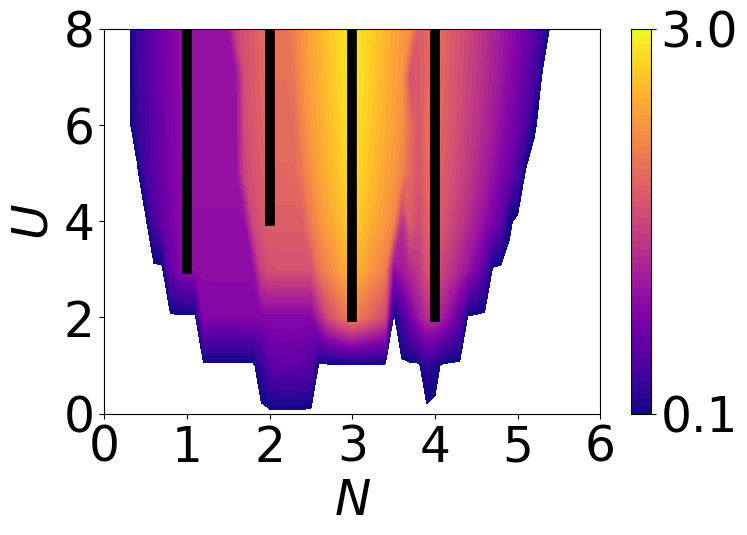

In [6]:
from hf.pyhf import outhf

for strain in ['a0.95', 'a1.00', 'a1.05']:
    oh = outhf.OutHF('dU1.0_UF8.0_sm', strain, 'G0', 0)
    oh.ShowBandDOS(8, 2, ep=0.2, is_unfold=1)
    oh.ShowPhase(Nlevel=50)

In [21]:
from matplotlib.lines import Line2D

def ShowSample(strain):
    fig, ax = plt.subplots(1, 2, figsize=(9, 5), width_ratios=[2, 1], constrained_layout=True)
    dn = 'kdos_%s_m0.10/bins128_ep0.20.h5' % (strain)
    with h5py.File(ml.path_save+dn, 'r') as f: d = f['dos'][()][1000, :]
    d = np.reshape(d, (128, 128))
    
    p_list = np.array([[30, 82], [30, 100], [30, 40]])
    #hsp_points = [0, 20, 30, 61, 84, 104, 127]
    #hsp_labels = [r'$\Gamma$', 'Z', '', 'S', 'X', 'U', 'R']
    hsp_points = [0, 24, 30, 48, 127]
    hsp_labels = [r'$\Gamma$', 'X', '', 'M', 'R']
    #for i in hsp_points: ax[0].axvline(x=i, lw=1, color='dimgrey', alpha=0.7)
    #ax[0].axhline(y=63, lw=1, color='dimgrey', alpha=0.7)
    ax[0].axvline(x=30, lw=3, ls='--', color='grey', alpha=0.4)
    
    ax[0].scatter(p_list[:, 0], p_list[:, 1], marker='s', s=200, color='red')
    ax[0].set_xticks(hsp_points, labels=hsp_labels)
    ax[0].set_yticks([0, 63, 127], labels=[-8, 0, 8])
    ax[0].set_ylabel(r'$E-E_F$')
    ax[0].set_ylim([-5, 132])
    
    for xi, yi in p_list:
        dos = d[xi, yi]
        x, y = np.array([[0, xi, 210], [yi, yi, yi]])
        line = Line2D(x, y, lw=3, ls='--', color='grey', alpha=0.4)
        ax[1].plot([-1, dos], [yi, yi], lw=3, ls='--', color='grey', alpha=0.4)
        ax[1].scatter([dos], [yi], s=100, color='tab:blue')
        line.set_clip_on(False)
        ax[0].add_line(line)
    
    ax[1].plot(d[30, :], range(128))
    ax[1].set_xticks([0, 5])
    ax[1].set_yticks([0, 63, 127], labels=['', '', ''])
    ax[1].set_ylabel(' ')
    ax[1].set_xlim([-0.5, 6])
    ax[1].set_ylim([-5, 132])
    fig.savefig('mlmag/fig/sample.pdf')
    plt.show()

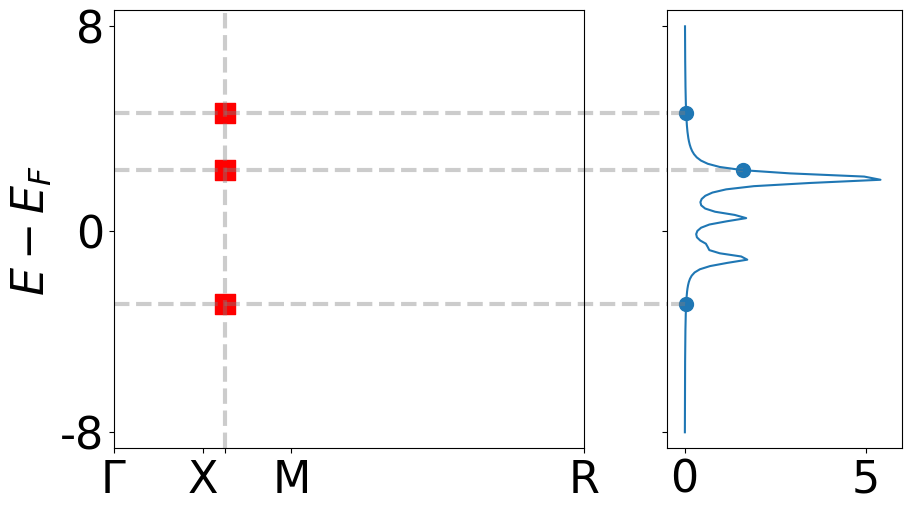

In [22]:
ShowSample('nost')

In [3]:
hsp_points = [0, 20, 60, 84, 104, 127]
#hsp_points = [0, 1, 2, 19, 20, 21, 60, 61, 62, 83, 84, 85, 103, 104, 105, 125, 126, 127]
#hsp_points = [0, 1, 2, 3, 4, 18, 19, 20, 21, 22, 59, 60, 61, 62, 63, 82, 83, 84, 85, 86, 102, 103, 104, 105, 106, 123, 124, 125, 126, 127]
print(len(hsp_points) / 128)

ftype = 'rf'
cnt_list = []
feats_list = []
for a in range(95, 106):
    strain = 'a%.2f' % (a * 0.01)
    ftn = 'kdos_%s_m0.10/bins128_ep0.20_%s.txt' % (strain, ftype)
    feats = np.loadtxt(ml.path_save+ftn, dtype=str)
    x = [int(re.sub('x', '', ft.split('_')[0])) for ft in feats]
    cnt = len([xi for xi in x if xi in hsp_points])
    cnt_list.append(cnt)
    feats_list.append(len(feats))

print(cnt_list, np.average(cnt_list))
print(feats_list, np.average(feats_list))
print(np.average(cnt_list)/np.average(feats_list))

0.046875
[242, 242, 246, 249, 239, 147, 243, 260, 276, 266, 263] 243.0
[3523, 3532, 3659, 3728, 3721, 2487, 3692, 3713, 3678, 3621, 3647] 3545.5454545454545
0.06853670418707213


In [244]:
import matplotlib as mpl

def ShowHsp(ftype='rf'):
    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    
    #hsp_points = [0, 20, 60, 84, 104, 127]
    hsp_points = [0, 127, 20, 84, 60, 104]
    hsp_points = [p+i for p in hsp_points for i in [-1, 0, 1]]
    hsp_points = [p+1 if p < 2 else p for p in hsp_points ]
    hsp_points = [p-1 if p > 125 else p for p in hsp_points]
    print(hsp_points)

    #hsp_labels = [r'$\Gamma$', 'Z', 'S', 'X', 'U', 'R']
    hsp_labels = [r'$\Gamma$', 'R', 'Z', 'X', 'S', 'U']
    hsp_labels = [l for l in hsp_labels for i in range(3)]
    
    hsp_colors = mpl.colormaps['tab10'](range(6))
    hsp_colors = [a for a in  hsp_colors for _ in range(3)]
    
    hsp_markers = ['o', 'o', '^', '^', 's', 's']
    hsp_markers = [m for m in hsp_markers for _ in range(3)]
    
    hsp_styles = ['-', '-', '--', '--', '-.', '-.']
    hsp_styles = [s for s in hsp_styles for _ in range(3)]
    
    a_list = range(95, 106)
    
    v = 0
    for i, (p, l, c, m, s) in enumerate(zip(hsp_points, hsp_labels, hsp_colors, hsp_markers, hsp_styles)):
        if v == 0: cnt = np.zeros(len(a_list))
        for j, a in enumerate(a_list):
            strain = 'a%.2f' % (a * 0.01)
            ftn = 'kdos_%s_m0.10/bins128_ep0.20_%s.txt' % (strain, ftype)
            feats = np.loadtxt(ml.path_save+ftn, dtype=str)
            x = [int(re.sub('x', '', ft.split('_')[0])) for ft in feats]
            #cnt[j] += len([xi for xi in x if xi == p])
            cnt[j] += len([xi for xi in x if xi == p]) / len(feats)
        
        v += 1
        if v == 3:
            ax.plot(cnt, s, marker=m, ms=12, label=l, color=c, markeredgecolor='k')
            v = 0
        
    
    ax.legend(bbox_to_anchor=(0.94, 0.21), ncols=3, fontsize=20, labelspacing=0.02, handletextpad=0.3, handlelength=1.0, borderpad=0.3, borderaxespad=0.3, columnspacing=0.3)
    ax.set_xticks(range(len(a_list))[::5], labels=['0.95', '1.00', '1.05'])
    #ax.set_yticks([0, 63, 127], labels=[-8, 0, 8])
    ax.grid(True)
    ax.set_xlabel(r'$a / a_{0}$')
    ax.set_ylabel(r'$N_\mathbf{k} / N_\mathrm{total}$')
    #ax.set_ylim([-5, 132])
    plt.show()

[0, 1, 2, 125, 126, 127, 19, 20, 21, 83, 84, 85, 59, 60, 61, 103, 104, 105]


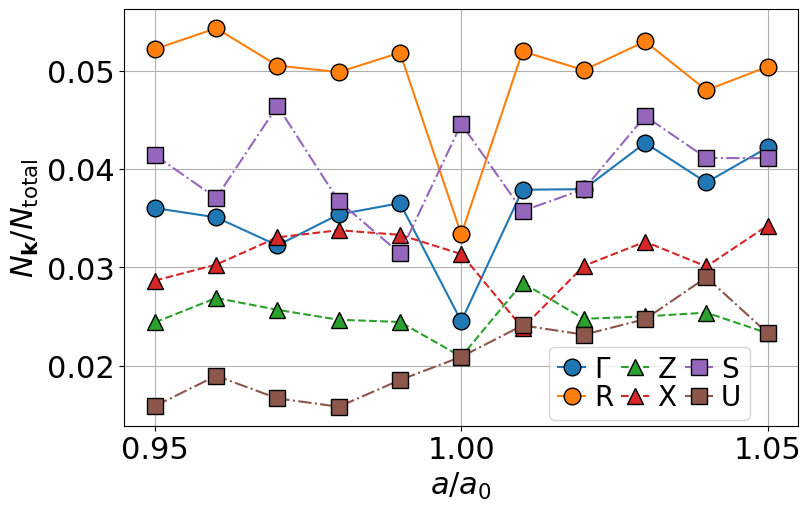

In [246]:
plt.rcParams.update({'font.size': 22})
ShowHsp()
plt.rcParams.update({'font.size': 32})


# Data : kdos_a0.95_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 16384->16384
# Resampler : none
# Accuracy : 0.915062 (808/883)
# Elapsed Time : 0.412819s


# Data : kdos_a0.96_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 16384->16384
# Resampler : none
# Accuracy : 0.903226 (812/899)
# Elapsed Time : 0.409239s


# Data : kdos_a0.97_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 16384->16384
# Resampler : none
# Accuracy : 0.919692 (836/909)
# Elapsed Time : 0.416855s


# Data : kdos_a0.98_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 16384->16384
# Resampler : none
# Accuracy : 0.922078 (852/924)
# Elapsed Time : 0.412461s


# Data : kdos_a0.99_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 16384->16384
# Resampler : none
# Accuracy : 0.916309 (854/932)
# Elapsed Time : 0.429483s


# Data : kdos_a1.00_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 16384->16384
# Resampler

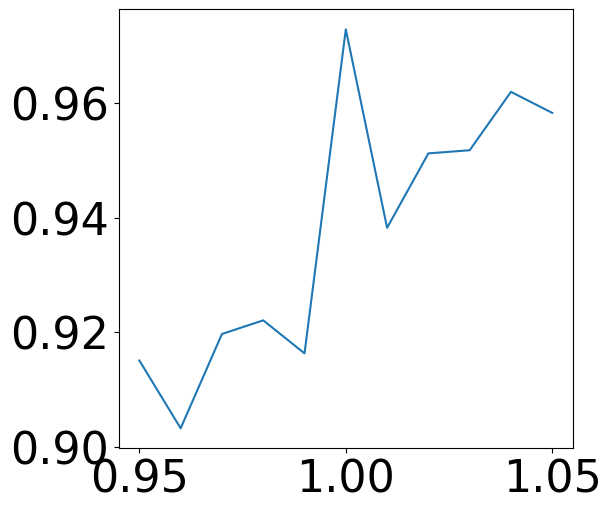

In [122]:
ShowAcc('kdos', 'none', 0.2)

In [59]:
def ShowCM(dtype, ftype='none', train_only=False):
    for strain in ['a0.95', 'a1.00', 'a1.05']:
        dn = '%s_%s_m0.10/bins128_ep0.20.h5' % (dtype, strain)
        if ftype != 'none': ftn = re.sub('.h5', '_%s.txt' % ftype, dn)
        else: ftn = 'none'
        if train_only: y = ml.Train(dn, 'rf', ftn, 'none')
        else: ShowConfMat(dn, 'rf', ftn, '')


# Data : kdos_a0.95_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 16384->16384
# Resampler : none
# Accuracy : 0.915062 (808/883)
# Elapsed Time : 0.408775s



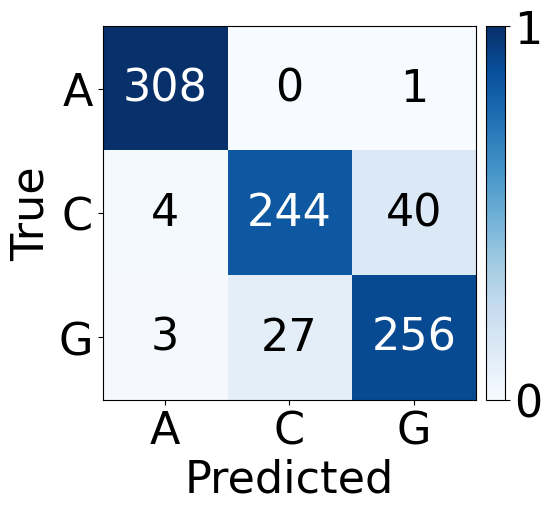


# Data : kdos_a1.00_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 16384->16384
# Resampler : none
# Accuracy : 0.972881 (861/885)
# Elapsed Time : 0.415177s



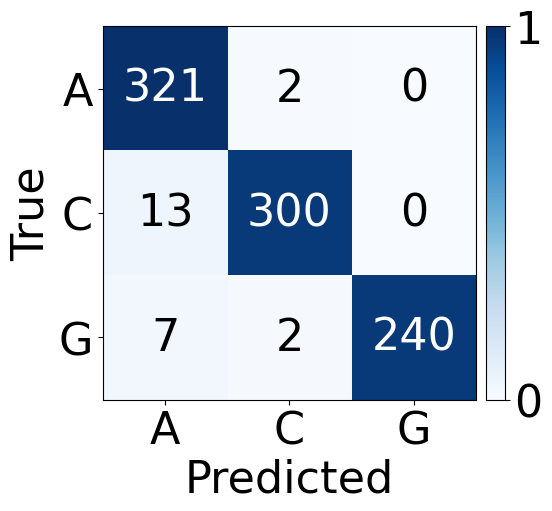


# Data : kdos_a1.05_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 16384->16384
# Resampler : none
# Accuracy : 0.958288 (873/911)
# Elapsed Time : 0.438435s



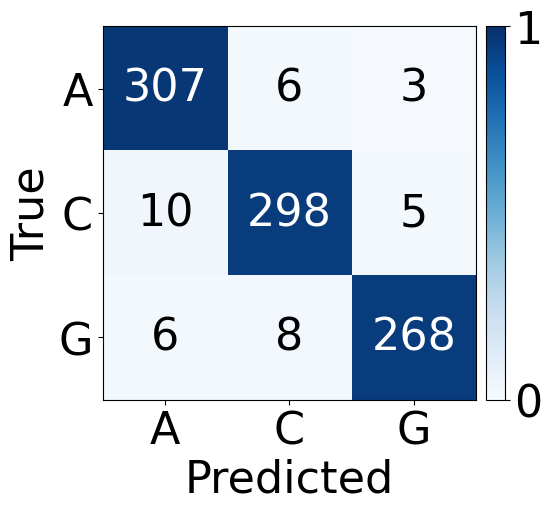

In [59]:
ShowCM('kdos')


# Data : hdos_a0.95_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 768->768
# Resampler : none
# Accuracy : 0.918460 (811/883)
# Elapsed Time : 0.198733s



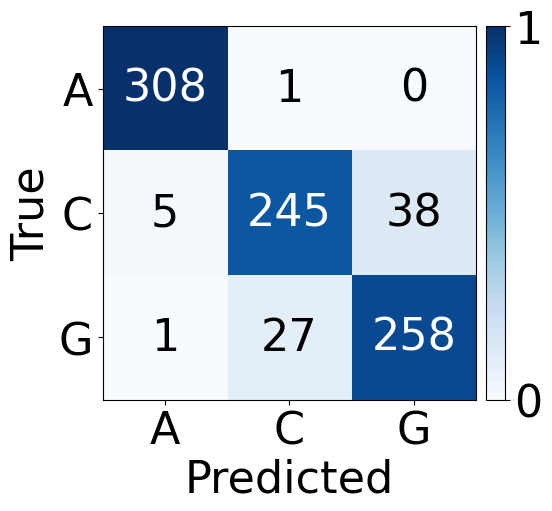


# Data : hdos_a1.00_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 768->768
# Resampler : none
# Accuracy : 0.979661 (867/885)
# Elapsed Time : 0.180308s



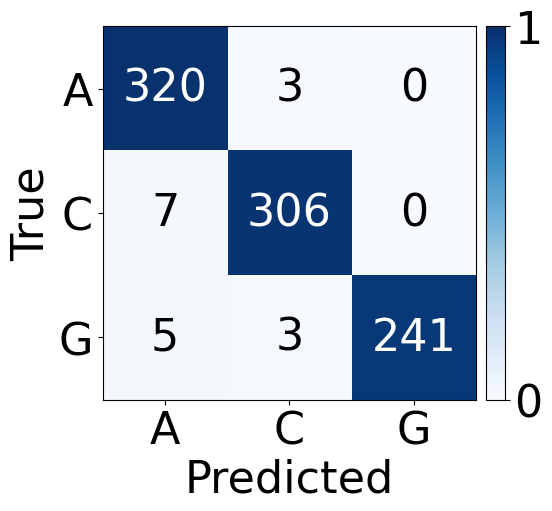


# Data : hdos_a1.05_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 768->768
# Resampler : none
# Accuracy : 0.967069 (881/911)
# Elapsed Time : 0.184842s



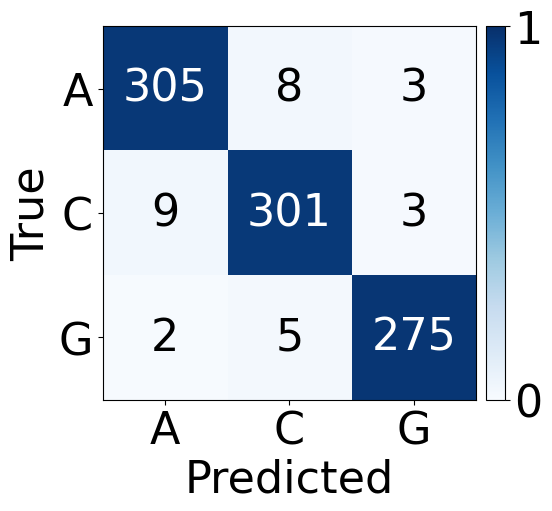

In [60]:
ShowCM('hdos')

In [27]:
def ShowFeat(strain, ftype):
    fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
    ftn = 'kdos_%s_m0.10/bins128_ep0.20_%s.txt' % (strain, ftype)
    feats = np.loadtxt(ml.path_save+ftn, dtype=str)
    
    x = []
    y = []
    for ft in feats:
        x.append(int(re.sub('x', '', ft.split('_')[0])))
        y.append(int(ft.split('_')[1]))
    # a값에 따라 hsp 에 있는 점 개수 세기 (x:a, y:feat 개수)
    
    #hsp_points = [0, 20, 61, 84, 104, 127]
    #hsp_labels = [r'$\Gamma$', 'Z', 'S', 'X', 'U', 'R']
    hsp_points = [0, 24, 48, 127]
    hsp_labels = [r'$\Gamma$', 'X', 'M', 'R']
    for i in hsp_points: ax.axvline(x=i, lw=1, color='dimgrey', alpha=0.7)
    ax.axhline(y=63, lw=1, color='dimgrey', alpha=0.7)
    
    ax.scatter(x, y, s=1)
    ax.set_xticks(hsp_points, labels=hsp_labels)
    ax.set_yticks([0, 63, 127], labels=[-8, 0, 8])
    ax.set_ylabel(r'$E-E_F$')
    ax.set_ylim([-5, 132])
    fig.savefig('mlmag/fig/%s.pdf' % ftype)
    plt.show()

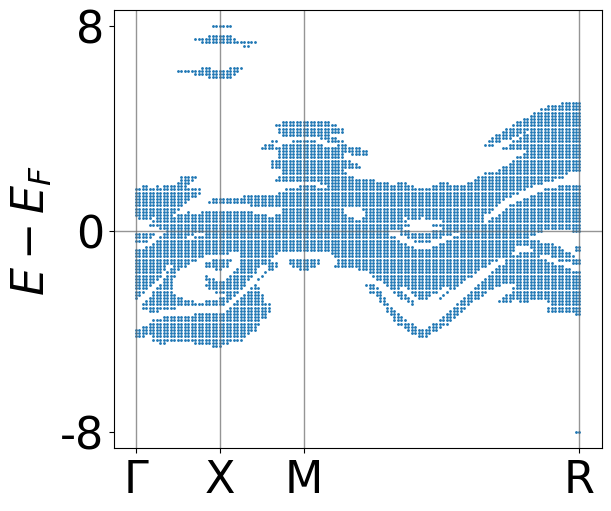

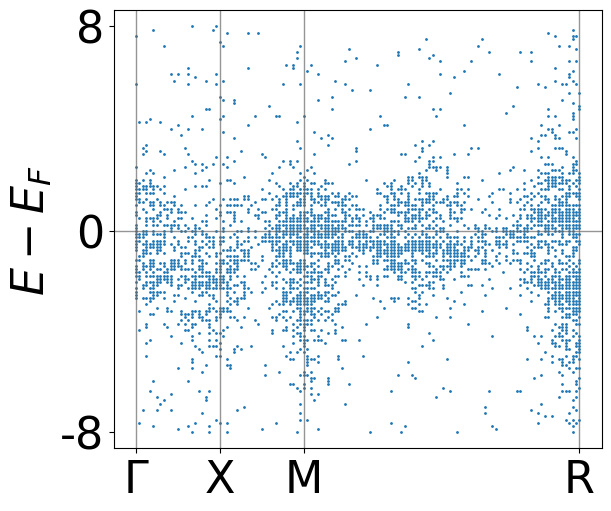

In [28]:
for strain in ['nost']:
    for ft in ['kb', 'rf']:
        ShowFeat(strain, ft)

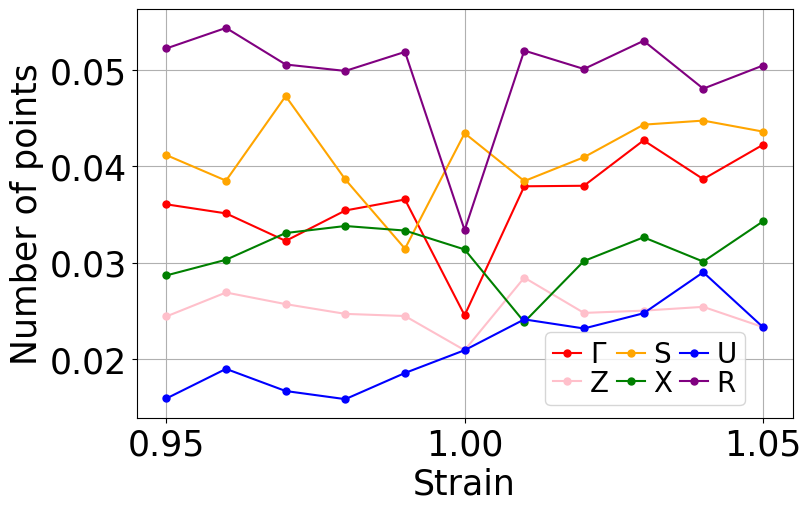

In [3]:
plt.rcParams.update({'font.size': 25})
ShowHsp()
plt.rcParams.update({'font.size': 32})

In [58]:
ShowCM('kdos', ftype='none', train_only=True)

NameError: name 'ShowCM' is not defined

In [99]:
ShowCM('hdos', ftype='none', train_only=True)


# Data : hdos_a0.95_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 768->768
# Resampler : none
# Accuracy : 0.918460 (811/883)
# Elapsed Time : 0.186201s


# Data : hdos_a1.00_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 768->768
# Resampler : none
# Accuracy : 0.979661 (867/885)
# Elapsed Time : 0.189328s


# Data : hdos_a1.05_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : none 768->768
# Resampler : none
# Accuracy : 0.967069 (881/911)
# Elapsed Time : 0.187410s




# Data : kdos_a0.95_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : kdos_a0.95_m0.10/bins128_ep0.20_kb.txt 16384->5000
# Resampler : none
# Accuracy : 0.921857 (814/883)
# Elapsed Time : 0.275557s



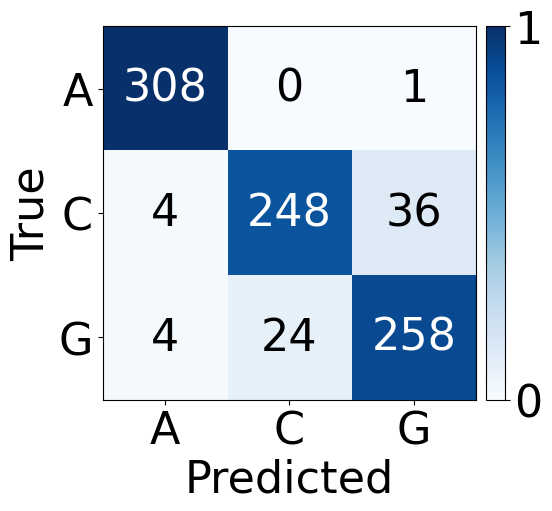


# Data : kdos_a1.00_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : kdos_a1.00_m0.10/bins128_ep0.20_kb.txt 16384->5000
# Resampler : none
# Accuracy : 0.976271 (864/885)
# Elapsed Time : 0.263796s



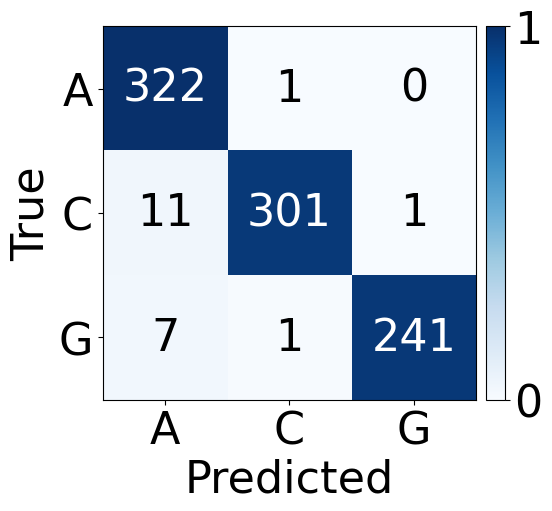


# Data : kdos_a1.05_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : kdos_a1.05_m0.10/bins128_ep0.20_kb.txt 16384->5000
# Resampler : none
# Accuracy : 0.958288 (873/911)
# Elapsed Time : 0.276003s



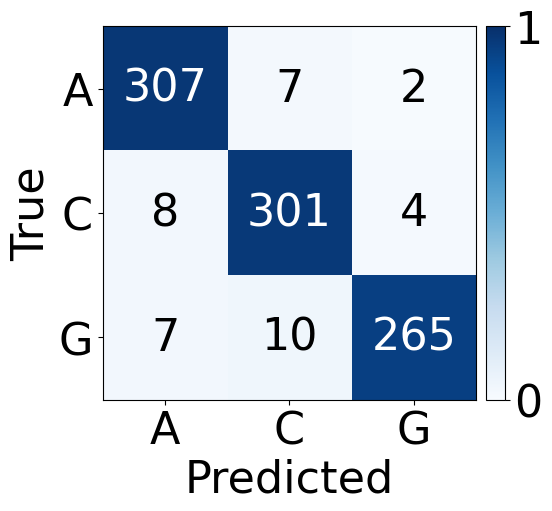

In [60]:
ShowCM('kdos', ftype='kb')


# Data : kdos_a0.95_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : kdos_a0.95_m0.10/bins128_ep0.20_rf.txt 16384->3523
# Resampler : none
# Accuracy : 0.921857 (814/883)
# Elapsed Time : 0.248366s



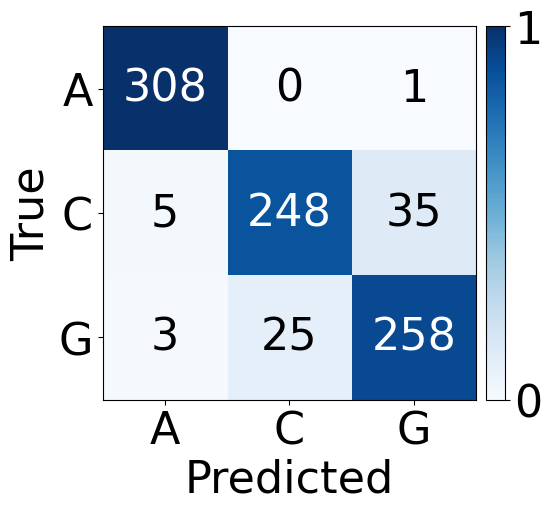


# Data : kdos_a1.00_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : kdos_a1.00_m0.10/bins128_ep0.20_rf.txt 16384->2487
# Resampler : none
# Accuracy : 0.979661 (867/885)
# Elapsed Time : 0.416955s



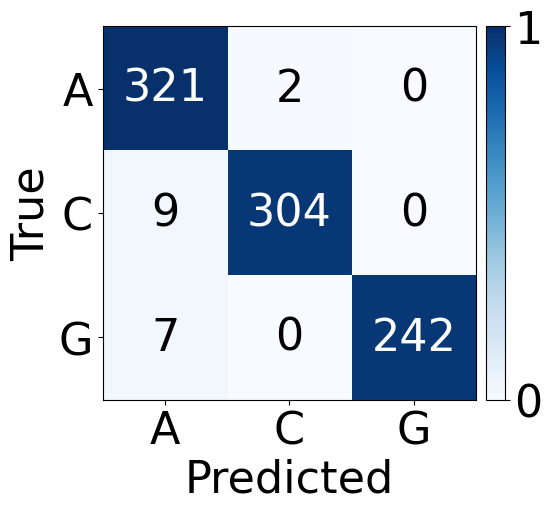


# Data : kdos_a1.05_m0.10/bins128_ep0.20.h5
# Machine : rf
# Feature selector : kdos_a1.05_m0.10/bins128_ep0.20_rf.txt 16384->3647
# Resampler : none
# Accuracy : 0.962678 (877/911)
# Elapsed Time : 0.250040s



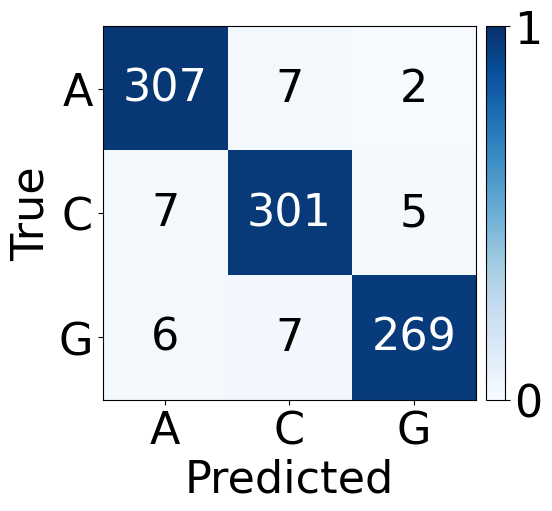

In [61]:
ShowCM('kdos', ftype='rf')